Dataset Preview:
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes           Yes       Other   
1  

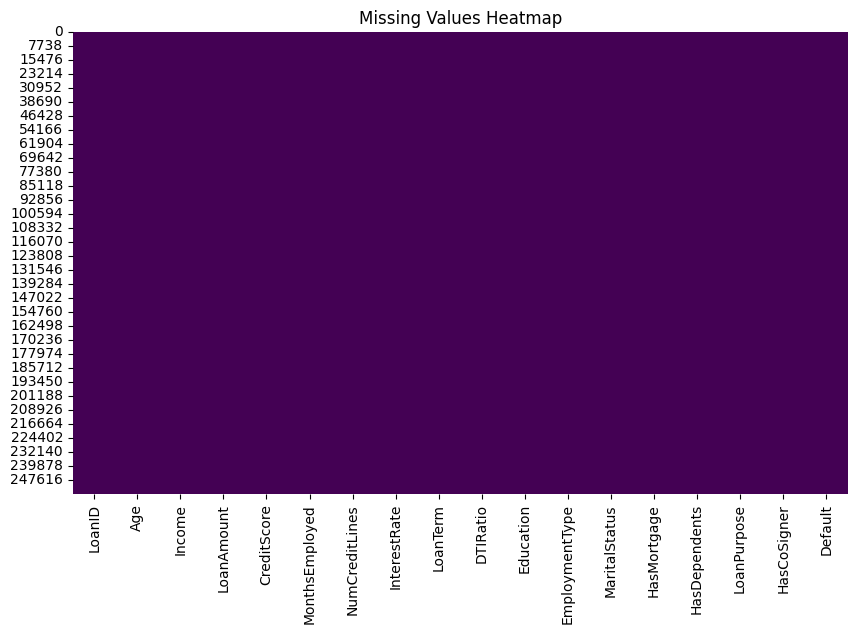

/var/folders/52/n3jglnhd3yj7lxpmdmd1vvh40000gn/T/ipykernel_5250/1679392840.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Default'], palette='pastel')


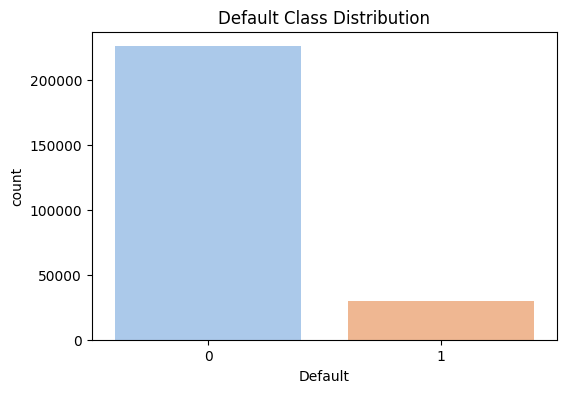

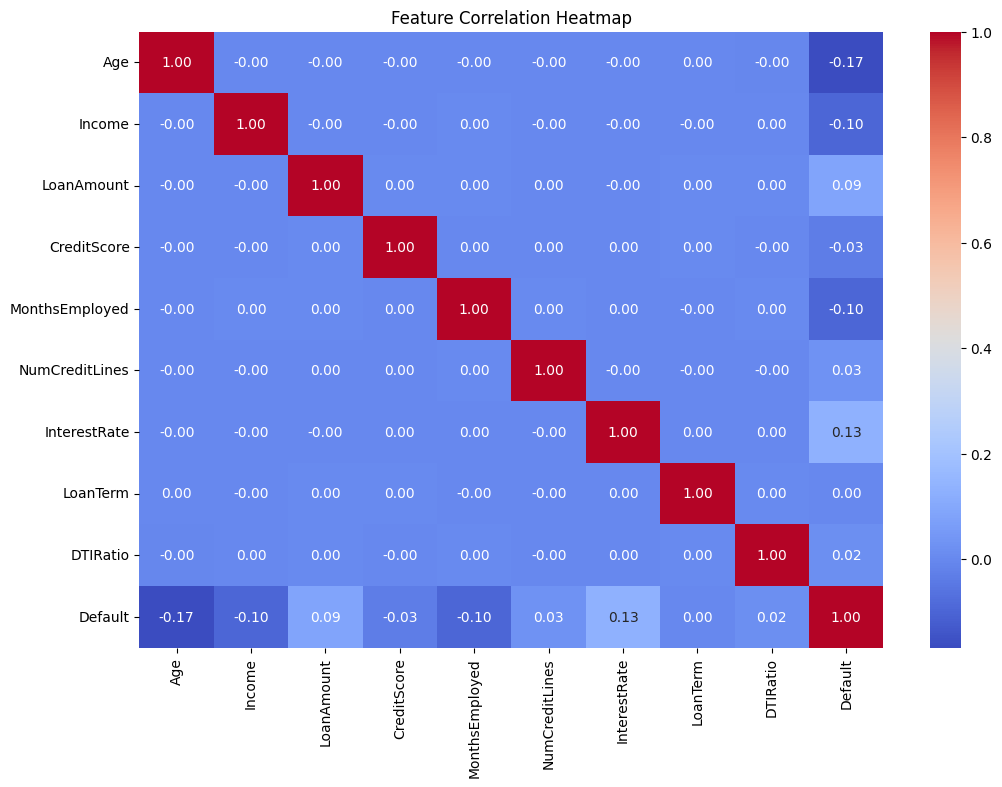

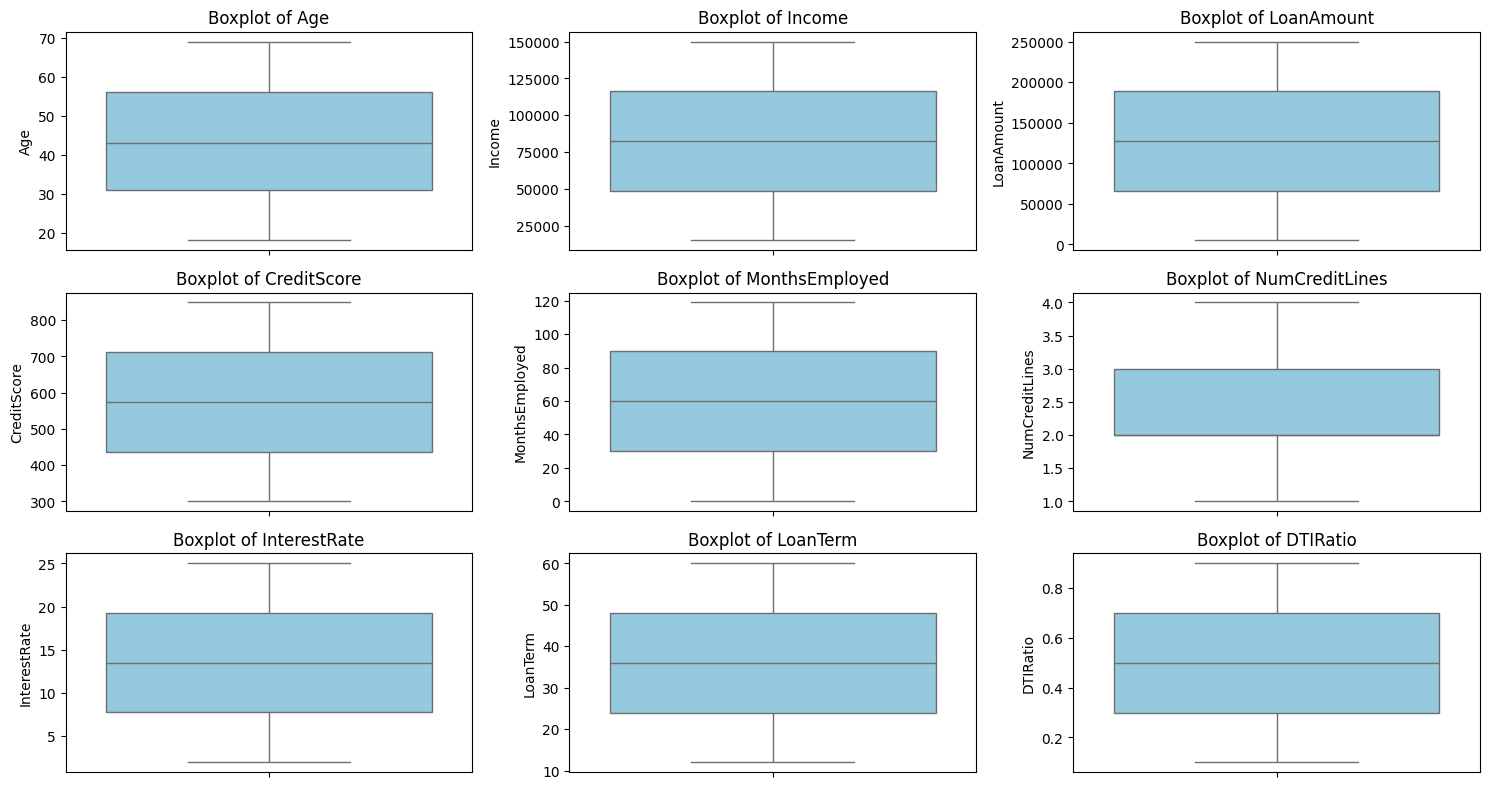

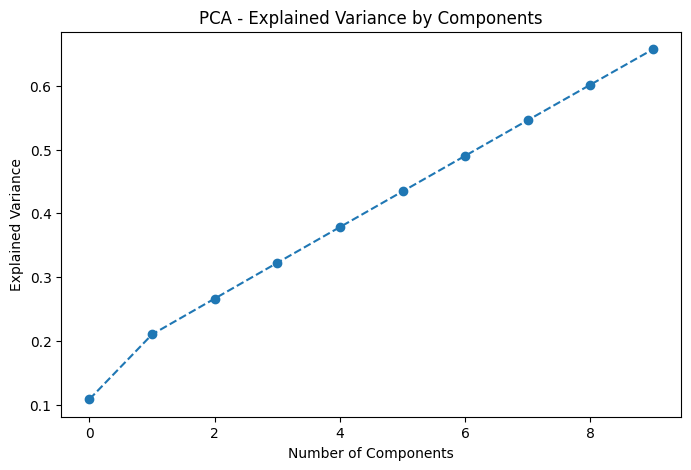

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Model Accuracy: 0.8853

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.58      0.03      0.05      5900

    accuracy                           0.89     51070
   macro avg       0.73      0.51      0.49     51070
weighted avg       0.85      0.89      0.84     51070



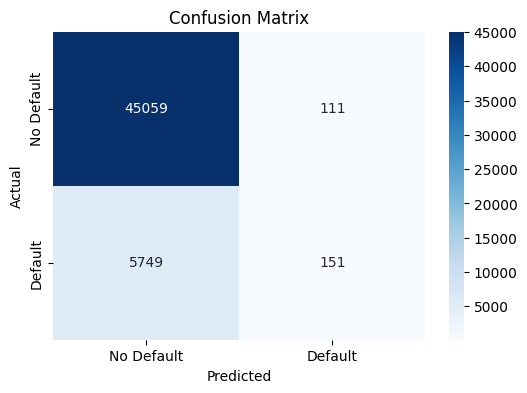

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

file_path = 'Loan_default.csv'
df = pd.read_csv(file_path)

print("Dataset Preview:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values[missing_values > 0])

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=df['Default'], palette='pastel')
plt.title("Default Class Distribution")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 
                      'InterestRate', 'LoanTerm', 'DTIRatio']
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

education_mapping = {'High School': 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}
employment_mapping = {'Unemployed': 0, "Self-employed": 1, "Part-time": 2, "Full-time": 3}
marital_mapping = {'Divorced': 0, "Single": 1, "Married": 2}
mortgage_mapping = {'No': 0, "Yes": 1}
dependent_mapping = {'No': 0, "Yes": 1}
purpose_mapping = {'Other': 0, "Business": 1, "Education": 2, "Auto": 3, "Home": 4}
cosigner_mapping = {'No': 0, "Yes": 1}

df['education_label'] = df['Education'].map(education_mapping).fillna(0)
df['employment_label'] = df['EmploymentType'].map(employment_mapping).fillna(0)
df['marital_label'] = df['MaritalStatus'].map(marital_mapping).fillna(0)
df['mortgage_label'] = df['HasMortgage'].map(mortgage_mapping).fillna(0)
df['dependent_label'] = df['HasDependents'].map(dependent_mapping).fillna(0)
df['purpose_label'] = df['LoanPurpose'].map(purpose_mapping).fillna(0)
df['cosigner_label'] = df['HasCoSigner'].map(cosigner_mapping).fillna(0)

df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['Income'] + 1)  # Avoid division by zero

df['CreditUtilization'] = df['NumCreditLines'] / (df['CreditScore'] + 1)

features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 
            'InterestRate', 'LoanTerm', 'DTIRatio', 'education_label', 'employment_label', 
            'marital_label', 'mortgage_label', 'dependent_label', 'purpose_label', 'cosigner_label', 
            'LoanToIncomeRatio', 'CreditUtilization']

X = df[features]
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA - Explained Variance by Components')
plt.show()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

print("\nBest Parameters:", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
